<a href="https://colab.research.google.com/github/EbunMak/MDSC507-NN-Assignment/blob/main/ebuinaramdsc507.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install TensorFlow docs notebook tools
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
#Retrieve the file containing the data set used in building the Neural Network
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
#Extract the dataset files 
!tar xf ucf101_top5.tar.gz

In [ ]:
#Import the following objects from the libraries 
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

#Import the following libraries and rename them
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

#Import the following libraries or modules
import imageio
import cv2
import os

In [ ]:
#Initialize and declare the following constant variables that store hyperparameters
IMG_SIZE = 224
#Number of samples from the training data that goes throught the network (i.e. size of a batch)
BATCH_SIZE = 64
#Number of times the entire training dataset has passed through the network
EPOCHS = 10

#Hyperparameters that dictate size of data form fed into the network
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
# reads training data and testing data to dataframes
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

#prints how many videos will be tested and trained using length of dataframes:)
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

#displays random sample of 10 records from training data
train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
352,v_Punch_g25_c01.avi,Punch
570,v_TennisSwing_g22_c01.avi,TennisSwing
112,v_CricketShot_g25_c02.avi,CricketShot
194,v_PlayingCello_g19_c04.avi,PlayingCello
571,v_TennisSwing_g22_c02.avi,TennisSwing
138,v_PlayingCello_g11_c01.avi,PlayingCello
540,v_TennisSwing_g17_c02.avi,TennisSwing
189,v_PlayingCello_g18_c06.avi,PlayingCello
134,v_PlayingCello_g10_c04.avi,PlayingCello
259,v_Punch_g11_c02.avi,Punch


In [ ]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub

# crops frames to square of half the size of the smaller
# dimension of frame
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

# captures and crops frames at set interval until max frames reached. 
# if max not hit after video complete, pad with zeroes. 
# adds each processed frame to list of frames.
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
      # closes file reader
        cap.release()
      # returns processed frames as a numpy array
    return np.array(frames)


In [ ]:
# uses InceptionV3 model (trained on ImageNet-1k dataset,
# part of Keras Applications module) to extract features
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        #weights pre-determined because model already trained
        weights="imagenet",
        include_top=False,
        pooling="avg",
        # width, height, colour components
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
#NNs need values to be converted to numbers, creates pseudo-dictionary of ints
# corresponding to each video label string.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

In [ ]:
#prepares all data in dataframes using data preparation functions
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for testing model and parameters
def run_experiment():
    filepath = "/tmp/video_classifier"
    # snapshot of the weights of experiment case
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    # trains using given parameters
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    # tests accuracy against data from test dataframe
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Test video path: v_CricketShot_g02_c01.avi
  CricketShot: 69.25%
  Punch: 15.88%
  TennisSwing: 10.53%
  ShavingBeard:  2.95%
  PlayingCello:  1.39%



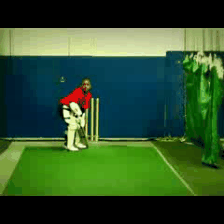

In [ ]:
#This is the inference section where we test a random video in our data set 

#Utility to convert a video into a form that is feedable to the sequence model
#by extracting features from the video frames
#This is the CNN implementation of this system
def prepare_single_video(frames):
    #Make a copy of the frames i.e. a new frames that does not 
    #reference the one passed to the function
    frames = frames[None, ...]
    #`frame_masks` and `frame_features` are what we will feed to our sequence model.
    #`frame_features` is a three dimensional array that will store the features of the video
    #`frame_masks` will contain booleans that denote if a timestep is masked with padding or not
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        #Store the minimum between the maximum sequence length and the actual length of the video
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            #Using the feature extraction model built above, make predictions 
            #by extracting features from the frame passed into the feature extractor
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        #Store true if frames not are masked with padding of zeroes
        #Denote false to be that  it is masked with padding
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked  
    return frame_features, frame_mask

#This function loads the extracted features from the frames of the video 
#into a sequence model and outputs the final predictions of the video classification.
#This is the RNN implementation of this system
def sequence_prediction(path):
    #store the labels of the videos as a list of strings
    class_vocab = label_processor.get_vocabulary()
    #Extract the frames of the video
    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    #
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    #For each predicted probability sorted index
    for i in np.argsort(probabilities)[::-1]:
        #Print out the label and its associated probabity as a percentage
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")    
    return frames


# This utility is for visualization.
#Takes in the frames of a video an embeds a gif of the video
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

#Choose a random video from the test data set to be tested by our network
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
#Call the sequence_prediction() function to classify the videos
#and store the returned frames
test_frames = sequence_prediction(test_video)
#Call the to_gif() function that visualizes a part of 
#the classified video in form of a gif
to_gif(test_frames[:MAX_SEQ_LENGTH])